# Setting up

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets, tree
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.random import set_seed

# Import data
from preprocessing import load_bikes_prepr

# Interpretability measures
from interpretability import PDP

import shap

In [ ]:
def find_best_model(model, parameters, X_train, y_train): 
    clf = GridSearchCV(model, parameters, scoring=('neg_root_mean_squared_error'), cv=KFold())
    clf.fit(X_train, y_train)

    return clf

def print_errors(clf, model_name, X_test, y_test):
    y_pred = clf.predict(X_test)

    if model_name == "Neural network":
        y_pred = np.reshape(y_pred, len(y_test))
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print("RMSE ({}): {}".format(model_name, rmse))
    r2 = r2_score(y_test, y_pred)
    print("R-squared score ({}) : {}".format(model_name, r2))

In [ ]:
X, y, feature_names = load_bikes_prepr()
seed = 3012

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
categorical = [True, True, True, True, True, True, True, True, False, False, False, False]

In [ ]:
"""
X_train_df = pd.DataFrame(data=X_train, columns=feature_names)
X_train_df
"""

'\nX_train_df = pd.DataFrame(data=X_train, columns=feature_names)\nX_train_df\n'

# Training models

## Sci-kit learn models

In [ ]:
model_names = [
    # "k-nearest neighbors regressor", 
    "decision tree regressor",
    "linear regression",
    ]

parameters = {
    "k-nearest neighbors regressor": {'n_neighbors': np.arange(2, 20), 'weights': ('uniform', 'distance')},
    "decision tree regressor": {'criterion': ('squared_error', 'friedman_mse', 'absolute_error', 'poisson')}, #, 'splitter': ('best', 'random') , 'min_samples_split': np.arange(2, 20)},
    "linear regression": {}
    }

models_init = {
    "k-nearest neighbors regressor": KNeighborsRegressor(),
    "decision tree regressor": tree.DecisionTreeRegressor(random_state=seed),
    "linear regression": LinearRegression()
    }

models = dict()

for model_name in model_names:
    clf = find_best_model(models_init[model_name], parameters[model_name], X_train, y_train)
    models[model_name] = clf.best_estimator_
    print(f"Training {model_name} done!")

Training decision tree regressor done!
Training linear regression done!


## Neural network

In [ ]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=seed)

In [ ]:
# Initialise neural network
BATCH_SIZE=64
INPUT_SIZE= X_train.shape[1]

set_seed(seed)

model = Sequential()
model.add(Input(INPUT_SIZE))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.1))
# model.add(Dense(10, activation="relu"))
# model.add(Dropout(0.1))
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam',
                loss="mean_absolute_error",
                metrics=['mean_squared_error'])

n_epochs = 600
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=n_epochs, validation_data=(X_val, y_val)) # validation_split=0.2)

models["neural network"] = model

174/174 [==============================] - 0s 2ms/step - loss: 86.1855 - mean_squared_error: 17803.4152 - val_loss: 74.0524 - val_mean_squared_error: 13772.8086
Epoch 102/600
174/174 [==============================] - 0s 2ms/step - loss: 86.2476 - mean_squared_error: 17616.3351 - val_loss: 74.0451 - val_mean_squared_error: 13722.2744
Epoch 103/600
174/174 [==============================] - 0s 3ms/step - loss: 86.2595 - mean_squared_error: 17537.5301 - val_loss: 74.4299 - val_mean_squared_error: 13863.8936
Epoch 104/600
174/174 [==============================] - 0s 2ms/step - loss: 85.7484 - mean_squared_error: 17317.9996 - val_loss: 74.2175 - val_mean_squared_error: 13886.5547
Epoch 105/600
174/174 [==============================] - 0s 1ms/step - loss: 87.9511 - mean_squared_error: 18066.6630 - val_loss: 74.0504 - val_mean_squared_error: 13829.6484
Epoch 106/600
174/174 [==============================] - 0s 2ms/step - loss: 85.3319 - mean_squared_error: 17098.9734 - val_loss: 74.1043 -

## Errors

In [ ]:
for model_name, model in models.items():
    print_errors(model, model_name, X_test, y_test)

RMSE (decision tree regressor): 58.94590711387484
R-squared score (decision tree regressor) : 0.892936277909009
RMSE (linear regression): 140.7242912588483
R-squared score (linear regression) : 0.3897986460392311


# Intrinsic interpretability

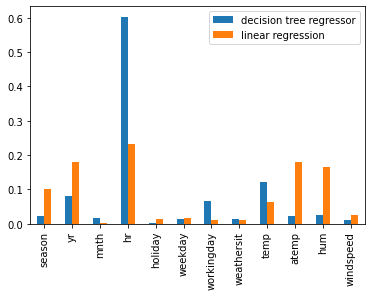

In [ ]:
dtr_feat_imps = models["decision tree regressor"].feature_importances_

linreg_coefs = models["linear regression"].coef_
linreg_feat_imps = np.abs(linreg_coefs) / np.sum(np.abs(linreg_coefs))

feat_imps = pd.DataFrame({"decision tree regressor": dtr_feat_imps, "linear regression": linreg_feat_imps}, index=feature_names)
feat_imps.plot.bar()
plt.show()

# Partial dependence plots

decision tree regressor


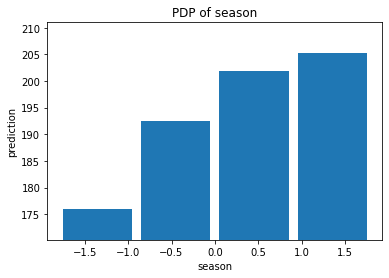

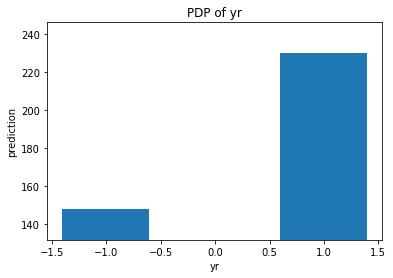

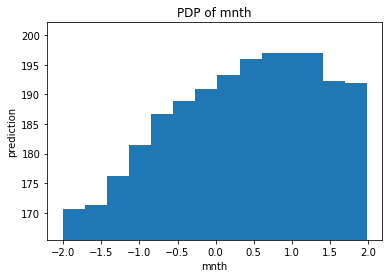

linear regression


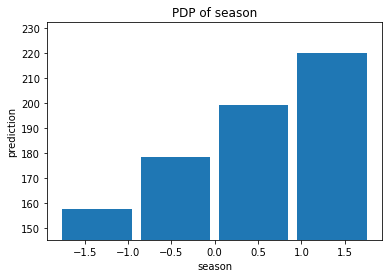

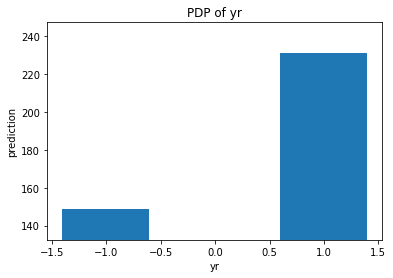

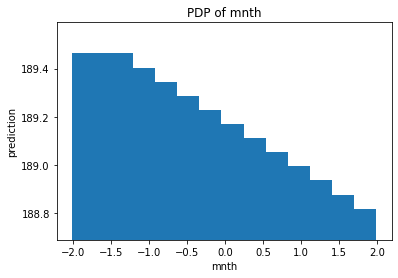

In [ ]:
categorical = [True, True, True, True, True, True, True, True, False, False, False, False]

for model_name in models.keys():
    model = models[model_name]
    print(model_name)

    for i in range(3): # range(X_test.shape[1]):
        PDP_values = PDP(i, feature_names[i], model, X_test, y_test, categorical=categorical[i])
        # print(PDP_values)
        plt.show()
        plt.close()

# SHAP

## Instance-based interpretation

In [ ]:
explainers = dict()

for model_name in models.keys():
  model = models[model_name]

  if model_name == "neural network":
    def nn_predict(X):
      y_pred = model.predict(X)
      y_pred = np.reshape(y_pred, X.shape[0])
      return y_pred

    explainers[model_name] = shap.KernelExplainer(nn_predict, shap.kmeans(X_train, 250))
  else:
    explainers[model_name] = shap.KernelExplainer(model.predict, shap.kmeans(X_train, 250))

Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


<BarContainer object of 12 artists>

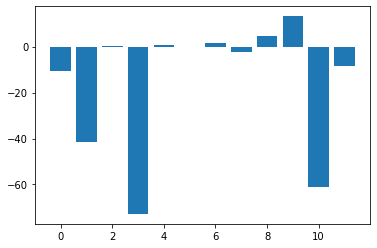

In [ ]:
idx = 5
model_name = "linear regression"

X_test_df = pd.DataFrame(X_test, columns=feature_names)

explainer = explainers[model_name]
shap_test = explainer.shap_values(X_test_df.iloc[idx])

# PLOT SHAPLEY VALUES IN NORMAL WAY

plt.bar(np.arange(len(feature_names)), shap_test)

#shap.initjs()
#shap.force_plot(explainer.expected_value, shap_test ,X_test_df.iloc[idx])

## Global interpretation

In [ ]:
shap_values_all = dict()
X_test_df = pd.DataFrame(X_test, columns=feature_names)

for model_name in models.keys():
    print(model_name)
    explainer = explainers[model_name]

    shap_values = explainer.shap_values(X_test_df.iloc[:7]) # Allemaal sampelen (gaat mss te veel zijn)
    shap_values_all[model_name] = shap_values

decision tree regressor


  0%|          | 0/7 [00:00<?, ?it/s]

linear regression


  0%|          | 0/7 [00:00<?, ?it/s]

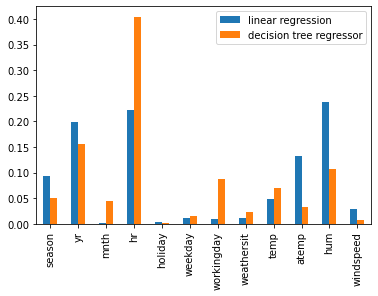

In [ ]:
shapley_feat_imps = pd.DataFrame(index=feature_names)

for model_name in models.keys():
  shap_values = shap_values_all[model_name]
  feat_imps = np.mean(np.abs(shap_values), axis=0)
  feat_imps /= np.sum(feat_imps)
  shapley_feat_imps.insert(0, model_name, feat_imps)

shapley_feat_imps.plot.bar()
plt.show()

# Counterfactuals

In [ ]:
categorical = [True, True, True, True, True, True, True, True, False, False, False, False] # meegeven bij preprocessing module
categorical_values = list()

for i in range(len(feature_names)):
  if categorical[i]:
    categorical_values.append(np.unique(X_train[:, i]))
  else:
    categorical_values.append(None)

In [ ]:
def postproces_nn(y_pred_nn):
  return np.reshape(y_pred_nn, y_pred_nn.shape[0])

In [ ]:
instance_idx = 3012
n_counterfactuals = 10
update_time = 5000
model_name = "linear regression" 
features_to_vary = categorical
# features_to_vary = [True] * len(feature_names)
limit_varied_features = True
goal_pred = 10.0
alpha = 1.0
tol = 2.0

model = models[model_name]

np.random.seed(seed)

instance = X_test[instance_idx]
instance = np.reshape(instance, (1, len(feature_names)))
original_pred = postproces_nn(model.predict(instance))[0]
print(f"Original prediction: {original_pred}")

counterfactuals = instance * np.ones((n_counterfactuals, len(feature_names)))
counterfactual_losses = np.ones(n_counterfactuals) * 100

update_counter = 0
total_counter = 0

while update_counter < update_time:
  counterfactual_found = False
  counter = 0
  prev_instance = np.copy(instance)

  while counter < 100 and not counterfactual_found:
    # Change a feature value randomly
    feature_idx = np.random.randint(len(feature_names))

    while not features_to_vary[feature_idx]:
      feature_idx = np.random.randint(len(feature_names))

    if categorical[feature_idx]:
      new_value = np.random.choice(categorical_values[feature_idx])
    else:
      minimum_value = np.min(X_train[:,feature_idx]) # extend this range
      maximum_value = np.max(X_train[:,feature_idx])
      new_value = np.random.random() * (maximum_value - minimum_value) + minimum_value
    
    new_instance = np.copy(prev_instance)
    new_instance[:,feature_idx] = new_value

    # Make a new prediction
    new_pred = postproces_nn(model.predict(new_instance))[0]
    
    # Check if new instance is a counterfactual
    if new_pred > goal_pred - tol and new_pred < goal_pred + tol:
      counterfactual_found = True
      counterfactual_loss = np.sum(np.abs(new_instance - instance)) + alpha * np.abs(new_pred - goal_pred)

      # Check if counterfactual already in the set
      # not (new_instance == counterfactuals).all(axis=1).any()

      # Standard counterfactual to replace is the one with the biggest loss value
      idx_to_replace = np.argmax(counterfactual_losses)

      # If varied features are limited we replace the instance with the same
      # varied features
      if limit_varied_features:
        counterfactuals_varied_features = ((counterfactuals - instance) != 0.0)
        varied_features = ((new_instance - instance) != 0.0)
      
        counterfactuals_with_same_varied_features = (varied_features == counterfactuals_varied_features).all(axis=1)

        if counterfactuals_with_same_varied_features.any():
          idx_to_replace = np.where(counterfactuals_with_same_varied_features)
      
      # Check if new loss value is smaller than the one we want to replace
      if counterfactual_loss < counterfactual_losses[idx_to_replace]:
        # Replace counterfactual in set with found instance
        counterfactuals[idx_to_replace] = new_instance
        counterfactual_losses[idx_to_replace] = counterfactual_loss
        
        print("---------------------------------------------------------------")
        print(f"Counts total: {total_counter}")
        print(f"Counts since last update: {update_counter}")
        print(f"Counterfactual losses: {counterfactual_losses}")

        update_counter = 0
    
    prev_instance = np.copy(new_instance)

    counter += 1
    
  update_counter += 1
  total_counter += 1

print("---------------------------------------------------------------")
print(f"Total counts: {total_counter}")
print(f"Counts since last update: {update_counter}")

sort_indices = np.argsort(counterfactual_losses)
counterfactual_losses = counterfactual_losses[sort_indices]
counterfactuals = counterfactuals[sort_indices]

# Niet-counterfactuals eruit halen eventueel

print(f"Counterfactual_losses: {counterfactual_losses}")

Original prediction: 133.28213693236268
---------------------------------------------------------------
Counts total: 3
Counts since last update: 3
Counterfactual losses: [  7.0483736 100.        100.        100.        100.        100.
 100.        100.        100.        100.       ]
---------------------------------------------------------------
Counts total: 13
Counts since last update: 10
Counterfactual losses: [  7.0483736   11.56168446 100.         100.         100.
 100.         100.         100.         100.         100.        ]
---------------------------------------------------------------
Counts total: 20
Counts since last update: 7
Counterfactual losses: [  7.0483736   11.56168446   5.47290557 100.         100.
 100.         100.         100.         100.         100.        ]
---------------------------------------------------------------
Counts total: 23
Counts since last update: 3
Counterfactual losses: [  7.0483736   11.56168446   5.47290557   3.88733628 100.
 100.   

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=90a57419-7b7b-4aa4-8a97-858f9f98a849' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>